In [56]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)


In [ ]:
# net = nn.Sequential(nn.Flatten(),nn.Linear(28*28,64),nn.Linear(64,10))
# net = nn.Sequential(nn.Flatten(),nn.Linear(28*28,10))

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

"""
使用一层感知机 最后准确率为0.8308
使用两层感知机，准确率为0.8345
添加relu 然后加上 Rropout 是0.8488
如果只添加relu 0.836
使用adam lr不能过大 0.0001 但准确率不高 只有0.8281


"""

def init_weights(m):
    if type(m) == nn.Linear:
        # nn.init.normal_(m.weight,std = 0.01)
        nn.init.zeros_(m.weight)

net.apply(init_weights)
"""
net.apply() 方法:

- 这是PyTorch中 nn.Module 类的一个方法
- 它会递归地遍历网络中的所有子模块（子层）
- 对每个模块调用传入的函数（这里是 init_weights )
"""

'\nnet.apply() 方法:\n\n- 这是PyTorch中 nn.Module 类的一个方法\n- 它会递归地遍历网络中的所有子模块（子层）\n- 对每个模块调用传入的函数（这里是 init_weights )\n'

### nn.init  
注意： _ 表示是原地操作，很多tensor 张量都有这个 避免了新开辟空间
nn.init 是PyTorch中用于初始化神经网络参数的模块，它提供了多种初始化方法，对模型训练的收敛速度和最终性能有重要影响。
常见的几种初始化方法:
- nn.init.normal_(tensor,mean = 0,std = 1.0)
- 均方分布初始化 nn.uniform_(tensor,a = 0.0,b = 1.0)
- 常数初始化 nn.init.constant(tensor,val)
- Xavier 初始化， 专为sigmod/tanh 激活函数设计，使得每层输出的方差大致相等
    - nn.init.Xavier_uniform_(tensor) 均方分布
    - nn.init.Xavier_normal_(tensor) 正态分布
- Kaiming 初始化 转为Relu 设计 考虑了非线性激活函数的特性
    - nn.init.Kaiming_uniform_(tensor,a=0,mode = 'fan_in')


In [58]:
loss = nn.CrossEntropyLoss(reduction = 'none')


CrossEntropy 包含了softmax操作
1. 首先对输入应用 log(softmax(x)) 操作，即对输入进行softmax归一化后取对数
2. 然后应用负对数似然损失函数
这种设计有两个主要优点：

1. 数值稳定性 ：直接计算 log(softmax(x)) 比先计算 softmax(x) 再计算 log(softmax(x)) 更稳定，可以避免我们之前讨论的数值溢出问题
2. 计算效率 ：将这两个操作合并可以更高效地计算梯度

reduction：参数决定了损失函数如何处理批量数据的损失值
- 1.'none' ：不进行任何降维操作，返回每个样本的损失值。这意味着如果输入批量大小为 N，则返回一个长度为 N 的张量，包含每个样本的单独损失值。这对于需要对每个样本的损失进行不同处理的情况很有用。
- 2.'mean' （默认值）：返回所有样本损失的平均值，即一个标量值。这是最常用的设置，因为通常我们希望最小化整个批量的平均损失。
- 3.'sum' ：返回所有样本损失的总和，也是一个标量值

In [59]:
trainier = torch.optim.Adam(net.parameters(),lr = 0.0001)


AssertionError: 0.5854446151733398

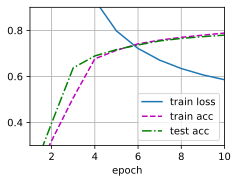

In [60]:
num_epochs = 10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainier)

In [ ]:
# 计算正确率 accuracy 计算当前这一批次 的准确率
def accuracy(y_hat,y):
    """
        传入格式 y_hat (batch_size,num_class)
        第一维度是每个样本，第二维度是每个样本对每一类的预测
        y 则 是(batch_size) 即每一个样本所属的类
    """
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        # 保证这个批次不只有一个样本，且class 大于1
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    # cmp 是一个bool 数组 相等的地方为true 其他未False
    return float(cmp.type(y.dtype).sum())
    # 返回预测正确的个数

class Accumulator:
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

# 评估
"""计算在指定数据集上模型的精度"""
def evaluate_accuracy(net,data_iter):
    # 传入网络和数据集
    if isinstance(net,torch.nn.Module):
        net.eval() # 将模型设置为评估模式

    metric = Accumulator(2) # 表示有两个变量 正确的和总量

    for x,y in data_iter:
        metric.add(accuracy(net(x),y),y.numel())
    
    return metric[0] / metric[1]
evaluate_accuracy(net,test_iter) # 算一个随机的初始化的精度

0.8281